<a href="https://colab.research.google.com/github/Taki123s/Project-ML/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connect Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/ML/Project'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/ML/Project


# **Import library**

In [2]:
!pip install scikit-learn==1.4.2 imbalanced-learn==0.9.1
!pip install scikeras[tensorflow]

In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense,InputLayer,Dropout
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier

# **Load dataset**

In [33]:
dataset = pd.read_csv("Customer-Churn-Records.csv")

#link file dataset của nhóm https://drive.google.com/file/d/1xna66LJxKYFBr_D58SnfdasUY6b_dUBu/view?usp=sharing

In [34]:
#các thuộc tính của dataset
dataset.dtypes

RowNumber               int64
CustomerId              int64
Surname                object
CreditScore           float64
Geography              object
Gender                 object
Age                   float64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

Def

In [83]:
# huấn luyện và tìm tham số tốt nhất cho mỗi thuật toán áp dụng gridsearchCV
def find_best_parameters(classifiers, X_train, y_train):
    best_classifiers = {}
    for clf_name, (clf, param_grid) in classifiers.items():
        grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
        grid.fit(X_train, y_train)
        best_classifiers[clf_name] = grid.best_estimator_
        print(f"Best parameters for {clf_name}: {grid.best_params_}")
    return best_classifiers

# thực hiện kiểm tra mô hình với test set bằng cách sử dụng các độ đo
def multiClassifiers(content,classifiers, X_test, y_test):
    results = {}
    for clf_name, clf in classifiers.items():
        y_pred = clf.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred, average='macro')
        recall = metrics.recall_score(y_test, y_pred, average='macro')
        f1 = metrics.f1_score(y_test, y_pred, average='macro')
        results[clf_name] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

    results_df = pd.DataFrame(results).T
    print(str(content))
    print(results_df)

# tạo mô hình neural network
def createModel(input_shape):
    model = Sequential()
    model.add(InputLayer(input_shape=(input_shape,)))
    model.add(Dense(250, activation='sigmoid'))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

#thực hiện kiểm tra mô hình bằng tập set và sử dụng các độ đo
def evaluateModel(model, X_test, y_test):
    results = {}
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype("int32")
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    results["Metrics"] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
    return results




# **Preprocessing**

 **Find Missing Values**

In [36]:
#tìm xem có chỗ nào bị thiếu dữ liệu không
missing_values_count = dataset.isnull().sum()
print("Số lượng giá trị thiếu trong mỗi cột:")
print(missing_values_count[missing_values_count > 0])

Số lượng giá trị thiếu trong mỗi cột:
CreditScore        15
Geography          46
Age                15
Balance             9
EstimatedSalary    31
Card Type           7
dtype: int64


**Processing Missing Values**

In [37]:
#xử lý các dữ liệu bị thiếu
dataset['CreditScore'].fillna(dataset['CreditScore'].mean(), inplace=True)
dataset['Age'].fillna(dataset['Age'].mean(), inplace=True)
dataset['Balance'].fillna(dataset['Balance'].mean(), inplace=True)
dataset['EstimatedSalary'].fillna(dataset['EstimatedSalary'].mean(), inplace=True)
dataset['Geography'].fillna(dataset['Geography'].mode()[0], inplace=True)
dataset['Card Type'].fillna(dataset['Card Type'].mode()[0], inplace=True)

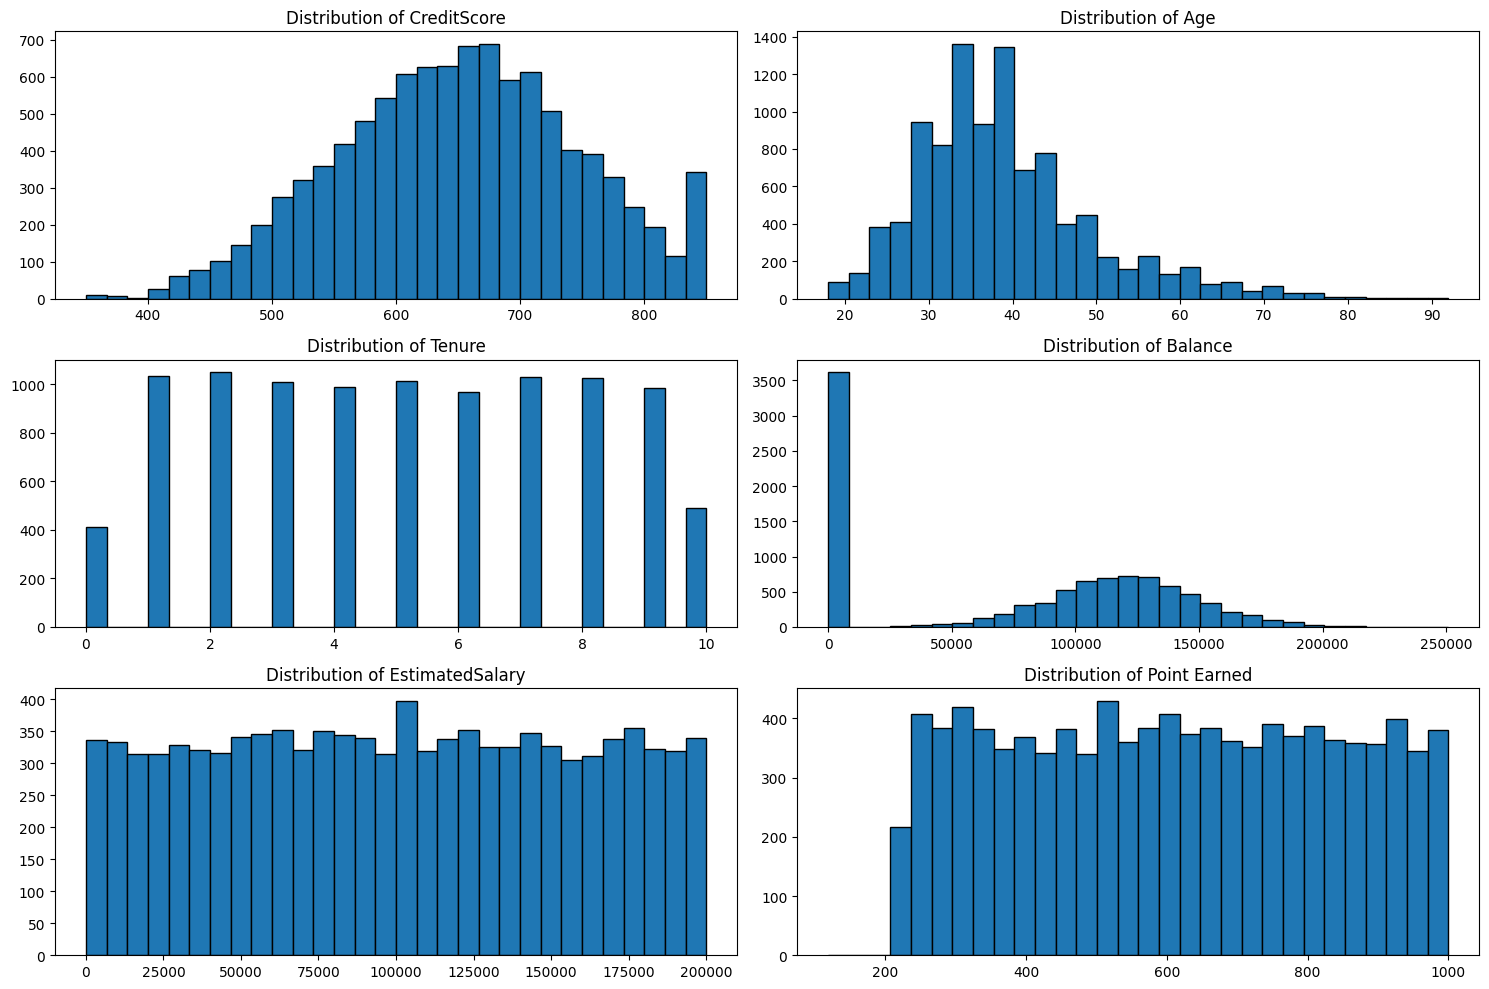

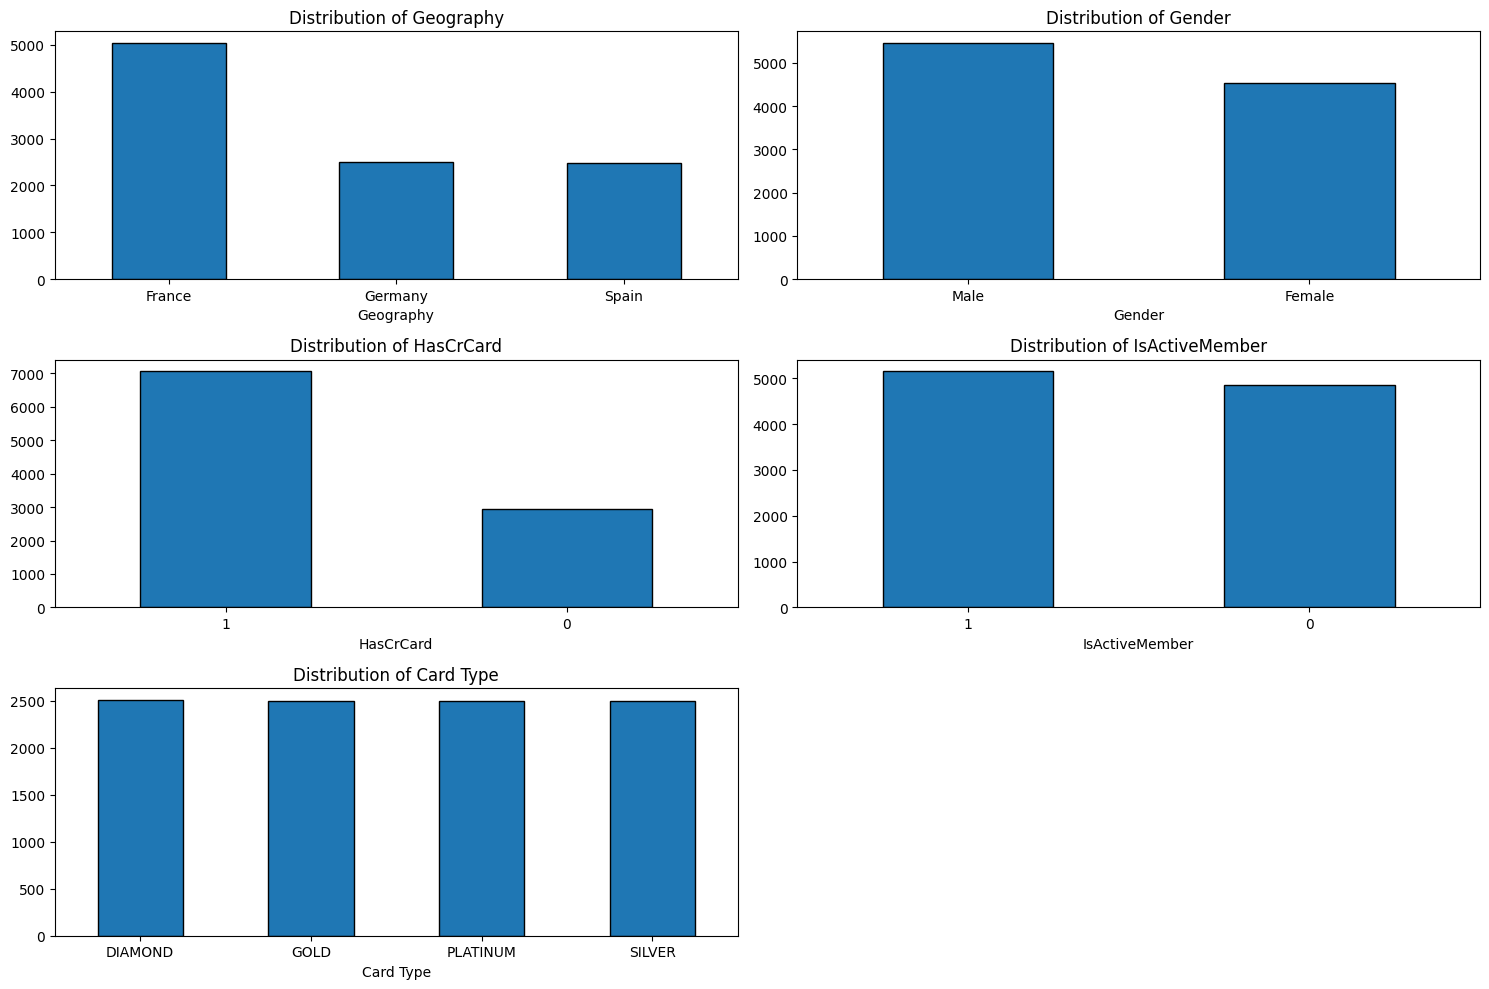

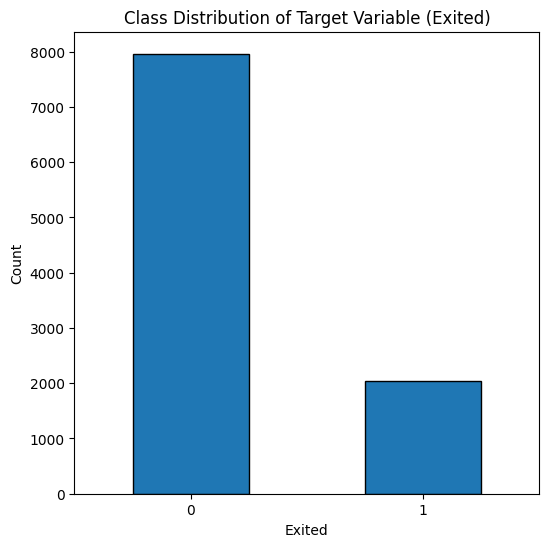

In [38]:
#Kiểm tra phân bố dữ liệu

#Phân bố của các thuộc tính số quan trọng
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    plt.hist(dataset[feature].dropna(), bins=30, edgecolor='k')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

#Phân bố của các thuộc tính danh mục
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Card Type']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    dataset[feature].value_counts().plot(kind='bar', edgecolor='k')
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#Kiểm tra phân bố của cột phân lớp xem có cân bằng không
plt.figure(figsize=(6, 6))
dataset['Exited'].value_counts().plot(kind='bar', edgecolor='k')
plt.title('Class Distribution of Target Variable (Exited)')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

**Standardized Data**

In [44]:
# Chuyển đổi các biến categorical thành dạng số
labelencoder = LabelEncoder()
dataset['Geography'] = labelencoder.fit_transform(dataset['Geography'])
dataset['Gender'] = labelencoder.fit_transform(dataset['Gender'])
dataset['Card Type'] = labelencoder.fit_transform(dataset['Card Type'])

#Loại bỏ dữ liệu trùng lặp
dataset = dataset.drop_duplicates()
#Bỏ các dữ liệu không liên quan
dataset = dataset.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

X = dataset.drop(['Exited'], axis=1) # 'RowNumber', 'CustomerId', 'Surname' các cột này là dữ liệu không liên quan đến việc huấn luyện
y = dataset['Exited']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
smote = SMOTE(random_state=42)
# Xử lý imbalance
X_train, y_train = smote.fit_resample(X_train, y_train)
# Chuẩn hóa dữ liệu số
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [45]:
#Sau khi xử lý
dataset.dtypes

CreditScore           float64
Geography               int64
Gender                  int64
Age                   float64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type               int64
Point Earned            int64
dtype: object

# **Training**

**Another Agorithm**

In [41]:
classifiers = {
    "Random Forest": (RandomForestClassifier(), {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}),
    "Logistic Regression": (LogisticRegression(max_iter=2000), {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}),
    "Naive Bayes": (GaussianNB(), {})
}

**Neuron**

In [84]:
optimizer = ['Adam', 'SGD', 'RMSprop']
batch_size = [128,140,150]
epochs = [15, 20]
param_grid = {"optimizer": optimizer, "batch_size": batch_size, "epochs": epochs}

In [87]:
input_shape = X_train.shape[1]
model = createModel(input_shape)
model = KerasClassifier(build_fn=model, verbose=1)
#GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, refit=True, verbose=1)
grid_result = grid.fit(X_train, y_train, validation_split=0.1)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7131 - loss: 0.5498 - val_accuracy: 0.9919 - val_loss: 0.1091
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9389 - loss: 0.1818 - val_accuracy: 0.9964 - val_loss: 0.0239
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9873 - loss: 0.0592 - val_accuracy: 0.9964 - val_loss: 0.0118
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9936 - loss: 0.0332 - val_accuracy: 0.9964 - val_loss: 0.0165
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9958 - loss: 0.0248 - val_accuracy: 0.9964 - val_loss: 0.0206
Epoch 6/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9960 - loss: 0.0238 - val_accuracy: 0.9964 - val_loss: 0.0238
Epoch 7/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9962 - loss: 0.0209 - val_accuracy: 0.9964 - val_loss: 0.0206
Epoch 8/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9976 - loss: 0.0184 - val_accuracy: 0.9964 - val_loss: 0.0225
Epo

# **Result**

In [82]:
best_classifiers = find_best_parameters(classifiers, X_train, y_train)
print(best_classifiers)
multiClassifiers("Results", best_classifiers,X_test, y_test)

Best parameters for Random Forest: {'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 6, 'n_estimators': 25}
Best parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Best parameters for Naive Bayes: {}
{'Random Forest': RandomForestClassifier(max_depth=9, max_leaf_nodes=6, n_estimators=25), 'Logistic Regression': LogisticRegression(C=10, max_iter=2000, solver='liblinear'), 'Naive Bayes': GaussianNB()}
Results
                     Accuracy  Precision    Recall  F1 Score
Random Forest        0.998667   0.997233  0.998523  0.997877
Logistic Regression  0.998333   0.997022  0.997667  0.997344
Naive Bayes          0.998667   0.997233  0.998523  0.997877


In [88]:
#Neural Network
print(f"Best parameters for Neural Network: {grid_result.best_params_}")
best_nn = grid_result.best_estimator_
evaluate = evaluateModel(best_nn,X_test, y_test)
print(pd.DataFrame(evaluate).T)

Best parameters for Neural Network: {'batch_size': 128, 'epochs': 15, 'optimizer': 'Adam'}
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
         Accuracy  F1 Score  Precision    Recall
Metrics  0.998667  0.997877   0.997233  0.998523
